# Rolling GeoMAD

* **Products used:** 
[gm_s2_rolling](https://explorer.digitalearth.africa/gm_s2_rolling),
[ndvi_anomaly](https://explorer.digitalearth.africa/s2_l2a)

## Background

Satellite imagery allows us to observe the Earth in a repetitive and detailed manner. However, missing data &mdash; such as gaps caused by cloud cover &mdash; can make it difficult to put together a complete image. In order to produce a single, complete view of a certain area, satellite data may be consolidated, stacking measurements from different points in time to create a composite image.

The Digital Earth Africa (DE Africa) Sentinel-2 Rolling GeoMAD (**Geo**median and **M**edian **A**bsolute **D**eviations) service provides monthly Geomedian and MADs calculated using a moving window of 3 months . This is a cloud-free time series that can be used to monitor change on a more frequent basis than an annual or semiannual product.

Each product combines measurements collected over a 3-month period to produce one representative, multi-spectral image for every pixel of the African continent for each calendar month. The end result is a comprehensive dataset that can be used either to generate true-colour images for visual inspection of the landsacpe, or the full spectral dataset can be used to develop more complex algorithms.

**Important details:**

* Datacube product names: `gm_s2_rolling`
* Geomedian surface reflectance product
    * Valid scaling range: `1 - 10,000`
    * `0` is `no data`
* Median Absolute Deviation product
    * Valid scaling range: Spectral MAD: `0 - 1` , Bray-Curtis MAD `0 - 1`, Euclidean MAD `0 - 10,000` 
    * `NaN` is `nodata`
* Status: provisional
* Date-range: October 2020 &ndash; present
* Spatial resolution: 10m

For more information on DE Africa's GeoMAD service, see the DE Africa [GeoMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html).

## Description

In this notebook we will work with the Sentinel-2 Rolling GeoMAD and demonstrate how it can be used to monitor changes in landscapes through time.

Topics covered include:
1. Inspecting the Rolling GeoMAD products and measurements available in the datacube
2. Load Rolling GeoMAD data
3. Display rgb of Rolling GeoMAD
4. Calculate and plot NDVI from Rolling GeoMAD
5. Inspect the MAD bands from the GeoMAD
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datacube
from datacube.utils.geometry import Geometry
from datetime import datetime

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='rolling_geomad')

### List measurements

Inspect the measurement or bands available for the Sentinel-2 Rolling GeoMAD using datacube's `list_measurements` functionality.

In [3]:
product_name = 'gm_s2_rolling'

dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype units  nodata                       aliases
measurement                                                            
B02            B02   uint16     1     0.0               [band_02, blue]
B03            B03   uint16     1     0.0              [band_03, green]
B04            B04   uint16     1     0.0                [band_04, red]
B05            B05   uint16     1     0.0         [band_05, red_edge_1]
B06            B06   uint16     1     0.0         [band_06, red_edge_2]
B07            B07   uint16     1     0.0         [band_07, red_edge_3]
B08            B08   uint16     1     0.0         [band_08, nir, nir_1]
B8A            B8A   uint16     1     0.0  [band_8a, nir_narrow, nir_2]
B11            B11   uint16     1     0.0    [band_11, swir_1, swir_16]
B12            B12   uint16     1     0.0    [band_12, swir_2, swir_22]
SMAD          SMAD  float32     1     NaN            [smad, sdev, SDEV]
EMAD          EMAD  float32     1     NaN            [emad, edev, EDEV]
BCMAD        BCMAD  float32     1     NaN         [bcmad, bcdev, BCDEV]
COUNT        COUNT   uint16     1     0.0                       [count]

### Define area of interest

In this example, we will inspect an area of sugarcane plantations in Zimbabwe. The GeoMAD is particularly suited to classification and change detection applications, such as in agriculture and forestry. We will see how the GeoMAD can be used to draw inferences about agricultural practices, such as harvest dates, later in the notebook.

In [4]:
#Specify the latitude, longitude, and buffer
aoi = define_area(lat=-21.07, lon=31.53, buffer=0.03)

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Display area of interest with a basemap using `display_map()`

In [5]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-2 Rolling GeoMAD data using `dc.load()`. 
For more discussion on how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

### Dealing with time

The rolling nature of this product means the loading behaviour for specified time periods is different to other Digital Earth Africa products. The reason is that there is temporal overlap between images. This is illustrated below in the chart which conceptualises the loading behaviour for the specified period `2021-01-01 - 2021-03-31` denoted by dotted black lines. As this period covers three months (Jan, Feb & Mar), users may expect the query to return three images. However, in the case of the rolling GeoMAD this will return five images as shown below. That's because the `dc.load` function will bring in all images that include image acquisitions within the time of interest. For example, the December 2020 GeoMAD includes images from November and December 2020, and January 2021, so will be loaded as part of the `2021-01-01 - 2021-03-31` query. The date label in the loaded dataset will be `2020-12-16`.

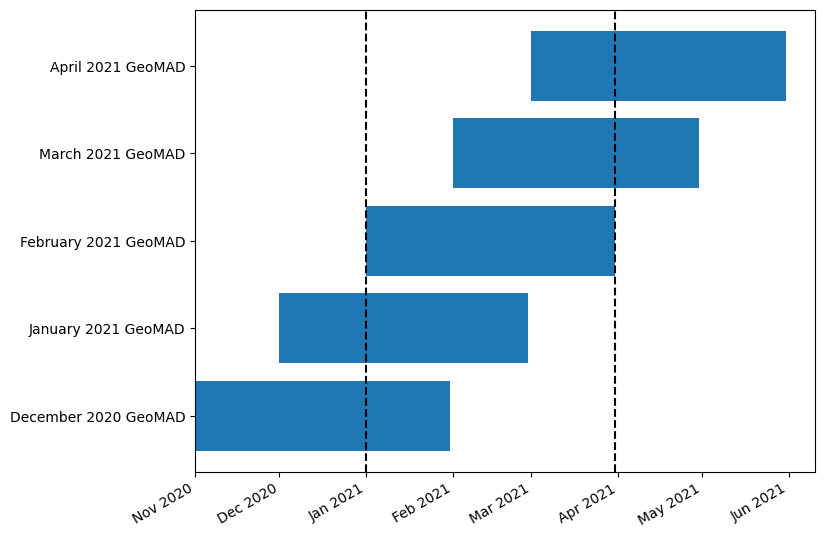

In [6]:
begin = np.array(["2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01", "2021-03-01"])
end =   np.array(["2021-01-31", "2021-02-28", "2021-03-31", "2021-04-30", "2021-05-31"])

begin = [datetime.strptime(i, "%Y-%m-%d") for i in begin]
end = [datetime.strptime(i, "%Y-%m-%d") for i in end]

event = ["December 2020 GeoMAD", "January 2021 GeoMAD", "February 2021 GeoMAD", "March 2021 GeoMAD", "April 2021 GeoMAD"]

fig, ax = plt.subplots(figsize=(8,6))

plt.barh(range(len(begin)),  [(end[i]-begin[i]) for i in range(len(begin))], left=begin)

plt.yticks(range(len(begin)), event)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.axvline(x=datetime.strptime("2021-01-01", "%Y-%m-%d"), linestyle='dashed', color='black')
ax.axvline(x=datetime.strptime("2021-03-31", "%Y-%m-%d"), linestyle='dashed', color='black')
plt.show()

The loading behaviour described above is evident in the `ds` returned below.

In [7]:
ds = dc.load(product="gm_s2_rolling",
             measurements=['red','green','blue','nir','emad', 'smad', 'bcmad'],
             x=lon_range,
             y=lat_range,
             resolution=(-20, 20),
             output_crs = 'epsg:6933',
             time=("2021-01","2021-12"),
             
             )
display(ds)

<xarray.Dataset>
Dimensions:      (time: 14, y: 359, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 2020-12-16T23:59:59.999999 ... 2022-01...
  * y            (y) float64 -2.626e+06 -2.626e+06 ... -2.633e+06 -2.633e+06
  * x            (x) float64 3.039e+06 3.039e+06 ... 3.045e+06 3.045e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 595 573 543 851 661 ... 1027 983 779 648
    green        (time, y, x) uint16 712 698 656 872 780 ... 1061 1026 929 886
    blue         (time, y, x) uint16 458 452 421 538 468 ... 661 728 704 638 597
    nir          (time, y, x) uint16 2634 2607 2514 2949 ... 3863 3712 3597 3663
    emad         (time, y, x) float32 1.858e+03 1.863e+03 ... 1.197e+03
    smad         (time, y, x) float32 0.02137 0.01984 ... 0.001466 0.002157
    bcmad        (time, y, x) float32 0.1483 0.1527 0.1337 ... 0.07304 0.07646
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

The cell below slices the beginning and end times to get the time range specified. Note that the `ds` object below only includes images labelled as `2021`.

In [8]:
ds_time = ds.time[1:-1]
ds = ds.sel(time=ds_time.values)
display(ds)

<xarray.Dataset>
Dimensions:      (time: 12, y: 359, x: 291)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-14T23:59:59.999999 ... 2021-12...
  * y            (y) float64 -2.626e+06 -2.626e+06 ... -2.633e+06 -2.633e+06
  * x            (x) float64 3.039e+06 3.039e+06 ... 3.045e+06 3.045e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 332 336 339 678 475 ... 1053 1007 802 636
    green        (time, y, x) uint16 583 602 557 781 693 ... 1027 983 900 838
    blue         (time, y, x) uint16 317 332 320 451 376 ... 640 704 678 622 561
    nir          (time, y, x) uint16 3159 3204 2827 3226 ... 3475 3392 3313 3353
    emad         (time, y, x) float32 883.5 698.1 756.0 ... 805.6 725.1 679.8
    smad         (time, y, x) float32 0.0004319 0.0004552 ... 0.001784 0.002771
    bcmad        (time, y, x) float32 0.0666 0.0551 0.05762 ... 0.05421 0.04862
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Display rgb of Sentinel-2 Rolling GeoMAD

We can plot the data we loaded using the `rgb()` function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.

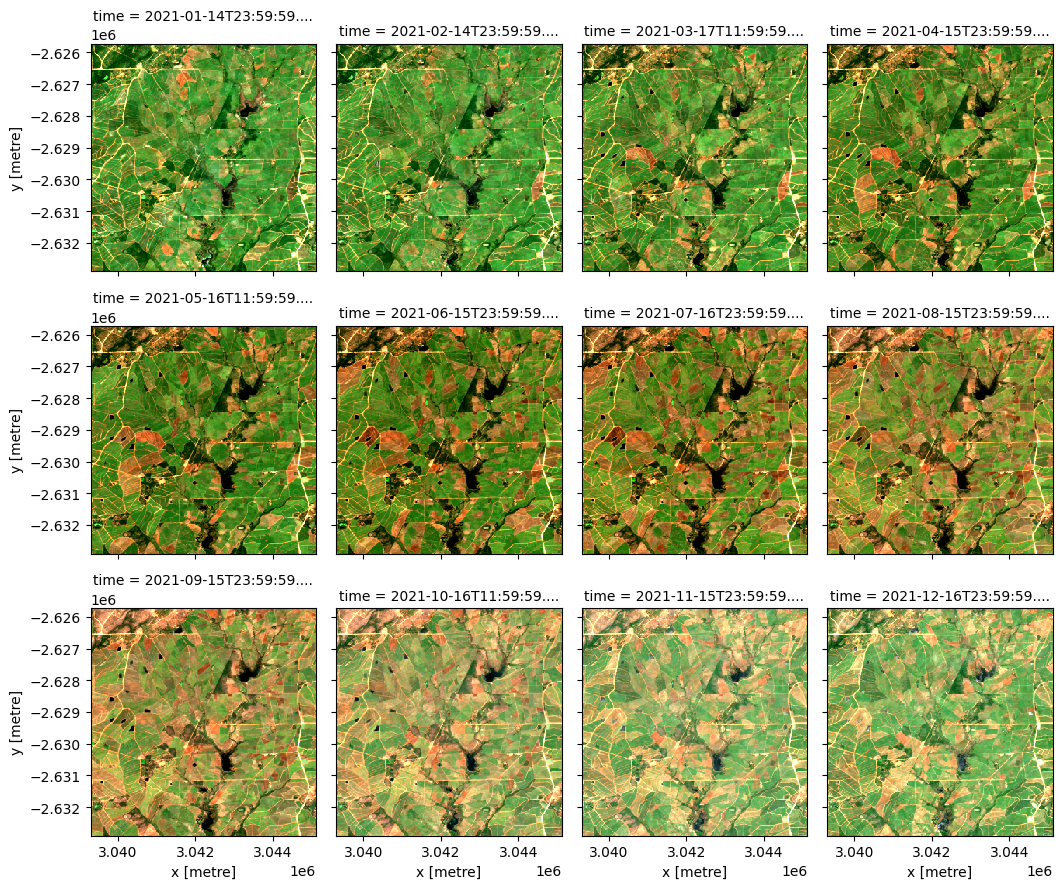

In [9]:
rgb(ds, col='time', col_wrap=4, size=3)

### Calculate NDVI using `calculate indices`
Refer to the [Calculating band indices](../Frequently_used_code/Calculating_band_indices.ipynb) notebook for more information. 
>Note: This product is suitable for calculating any indices, not just NDVI.

In [10]:
ds_NDVI = calculate_indices(ds, index=['NDVI'], satellite_mission='s2')

#### Plot NDVI

NDVI is plotted below for each month of 2021. Are there any noticeable patterns or changes in the distribution of NDVI in space?

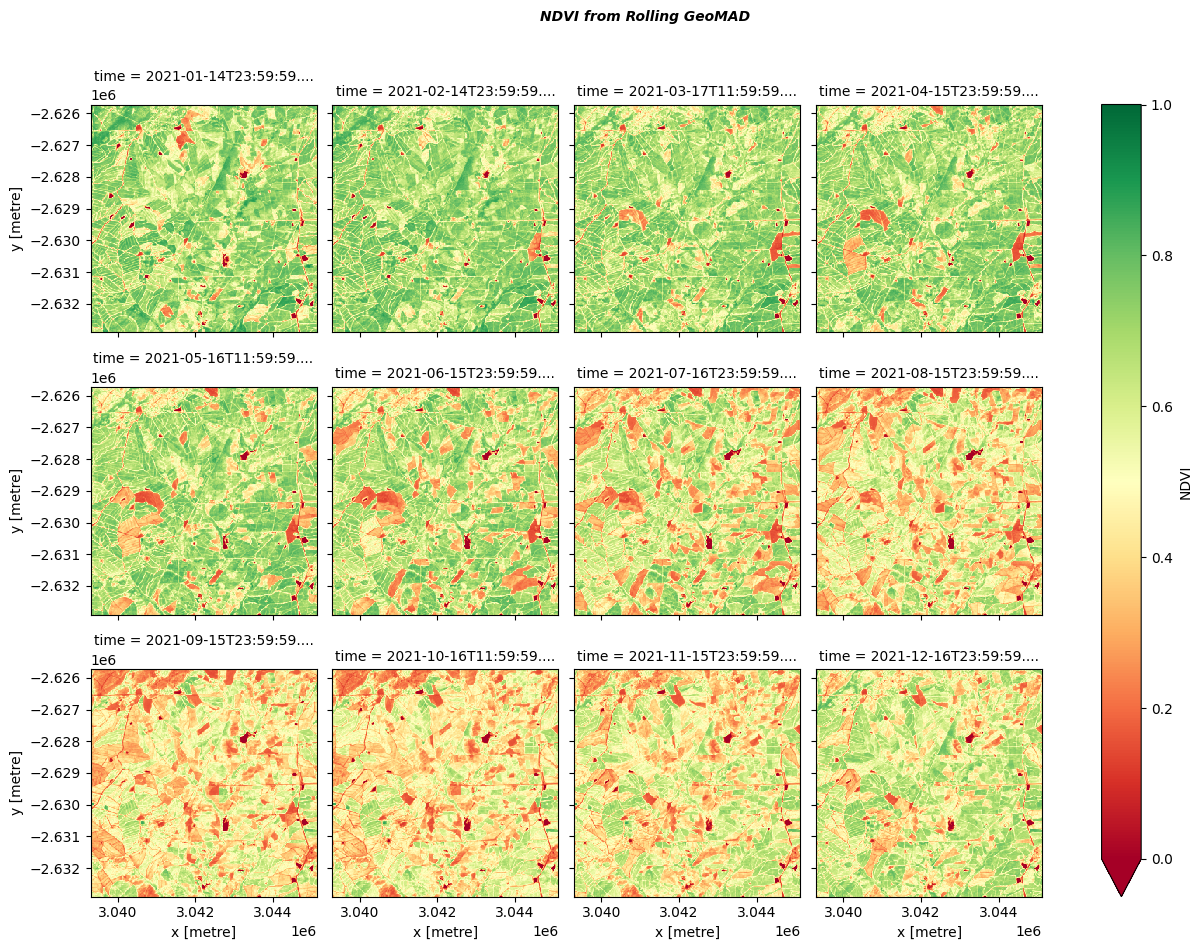

In [11]:
# NDVI Rolling GeoMAD
ds_NDVI.NDVI.plot(x='x',y='y', col='time', col_wrap = 4, vmin=0, vmax=1, 
                                           cmap='RdYlGn', robust=True)
                                                  
# Title NDVI Rolling GeoMAD
plt.suptitle('NDVI from Rolling GeoMAD', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})
                                                     
plt.show()

### Plot SMAD

The Median Absolute Deviation (MAD) bands provide information about change within the period of geomedian calculation. It does this while preserving the high-dimensional relationships between satellite bands. For example, higher spectral median absolute deviation (SMAD) values indicate a greater amount of change within a period. 

This information can help identify areas that are more dynamic in a given period. In managed (e.g. agricultural) environments, this can relate to activity like cultivation, harvest, or planting of crops.

Inspecting the images below, can you identify fields in the sugarcane plantation that have undergone change? Try comparing these fields with both the NDVI and rgb images above to see if you can draw any inferences about what has occurred.

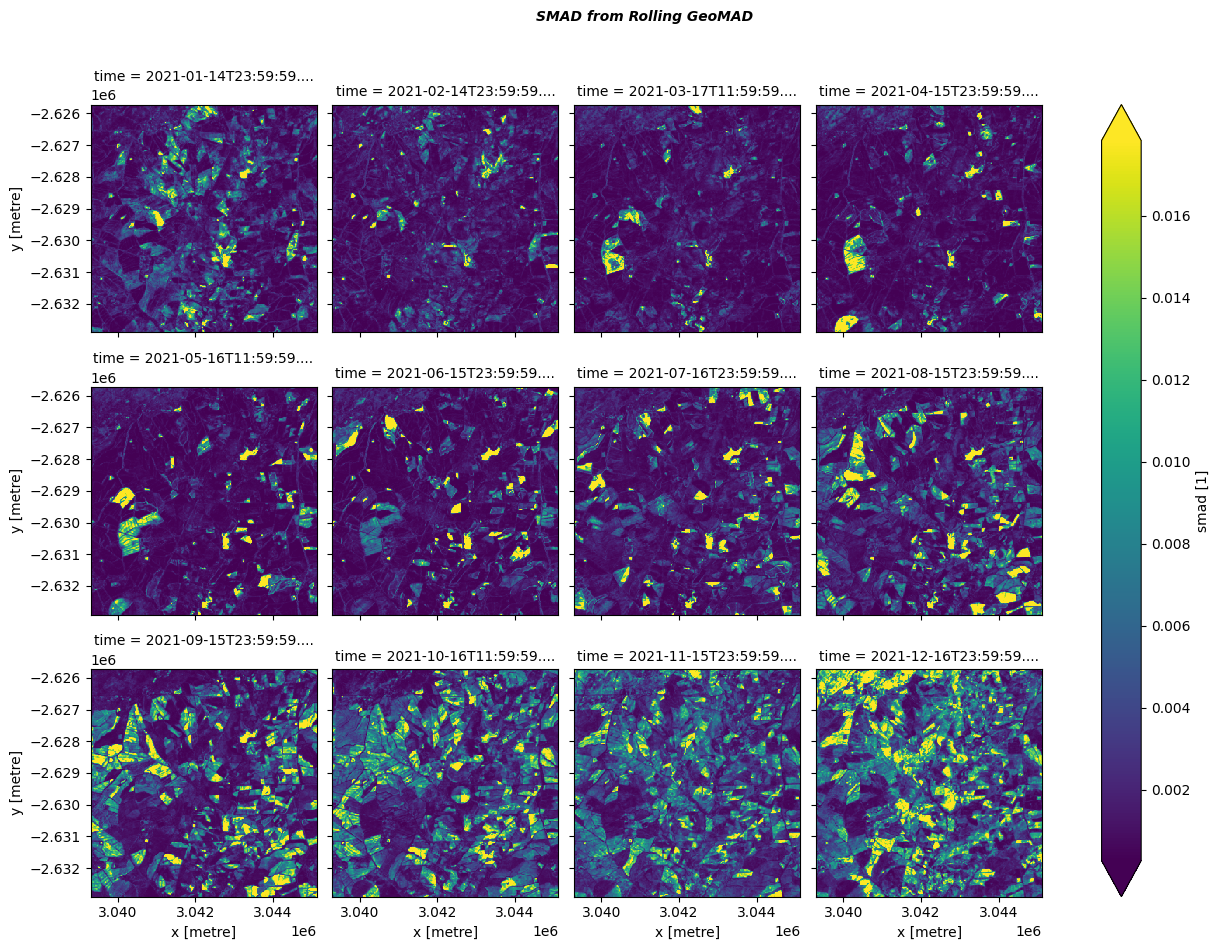

In [12]:
ds.smad.plot(x='x',y='y', col='time', col_wrap=4, cmap='viridis', robust=True)

plt.suptitle('SMAD from Rolling GeoMAD', y = 1.05, fontproperties={'style':'oblique', 'weight':'bold'})
                                                     
plt.show()

## Conclusion

This notebook has demonstrated loading and plotting the Rolling GeoMAD. It has also shown how the rolling nature of this product means that is has images that overlap in time, which has implications for loading procedures. 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-06-15'